#### Importando bibliotecas importantes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bruges

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve

In [2]:
def get_X(vps, depths, snr, wavelet_type):
    synths = []
    dt=0.002
    for i in range(len(vps)):
        #########################################################################
        vs = vps[i][:,0] / 2   # or use ones, doesn't matter for normal incidence
        rho = np.ones_like(vps[i][:,0])   # or use bruges.petrophysics.gardner()

        # Intervals
        dz = depths[1] - depths[0]
        # dt = 0.002   # 0.1 ms

        # Recorded time
        cumt = np.cumsum(dz / vps[i][:,0])

        # Target time basis
        t = np.arange(0, cumt[-1], dt)

        # Converted logs
        vp_t = np.interp(t, cumt, vps[i][:,0])
        vs_t = np.interp(t, cumt, vs)
        rho_t = np.interp(t, cumt, rho)

        rc = bruges.reflection.reflectivity(vp_t, vs_t, rho_t, theta=0)

        if wavelet_type=='ricker':
            wavelet = bruges.filters.ricker(0.512, dt, 120)
        elif wavelet_type=='ormsby':
            wavelet = bruges.filters.wavelets.ormsby(0.512, dt, (5,10,35,60))
        else:
            wavelet = bruges.filters.wavelets.gabor(0.512, dt, 25)

        # func = partial(np.convolve, v=w, mode='same')

        syn = np.convolve(rc, wavelet, mode='same')
        #########################################################################
        
        noise_synt = 0
        noise = np.random.normal(np.mean(syn.real), np.std(syn.real), len(syn))
        noise_synt = np.expand_dims(syn.real + noise*snr, axis=1)
        synths.append(noise_synt)
        
    return synths

#### função compute_misfit(y_pred, y_true)

Função para calcular o erro médio quadrático (MSE) entre os dados calculados e os dados de teste

In [3]:
def compute_misfit(y_pred, y_true):
    return np.sum(np.power(y_pred-y_true, 2))/y_true.shape[0]

#### função get_models(snr,wavelet_type)

Função para gerar os modelos sintéticos. Retorna o conjunto de modelos (profundidade dos refletores), o conjunto de campos de velocidade e o conjunto de traços. O traço obtido pode ou não conter ruído aleatório baseado na média e no desvio padrão do próprio traço sem ruído. O atributo snr varia de 0, para 0% de ruído, e 1 para 100% de ruído. 

In [4]:
def get_models():
    
    models = []
    vps = []
    rcs = []
    synths = []

    num_models = 21
    num_layers = 3
    num_depth = 60
    layer_points = int(num_depth / num_layers)
    layer_thickness = 200 # meters
    dz = layer_thickness/layer_points
    depths = np.linspace(0, 600, 60)

    for i in np.arange(num_models):
        model = np.zeros(num_layers)
        vp = np.zeros((num_depth,1))
        vs = np.ones((num_depth,1))
        rho = np.ones((num_depth,1))
        # first layer velocity
        perturb = np.random.randint(-100, 100)
        layer_vp = 1200 + perturb
        model[0] = layer_vp
        vp[:layer_points] = layer_vp

        for l in np.arange(1,num_layers):
            perturb = np.random.randint(-100, 100)
            layer_vp = (model[l-1] + 450) + perturb
            model[l] = layer_vp
            start_ind = int(l * layer_points)
            end_ind = int((l+1) * layer_points)
            #print('start: {}, end: {}'.format(start_ind, end_ind))
            vp[start_ind:end_ind] = layer_vp
            
        models.append(model)
        vps.append(vp)
        
    return models, vps, depths

### Estudo da resposta com o tipo de wavelet

Plotando os traços gerados a partir de diferentes wavelets

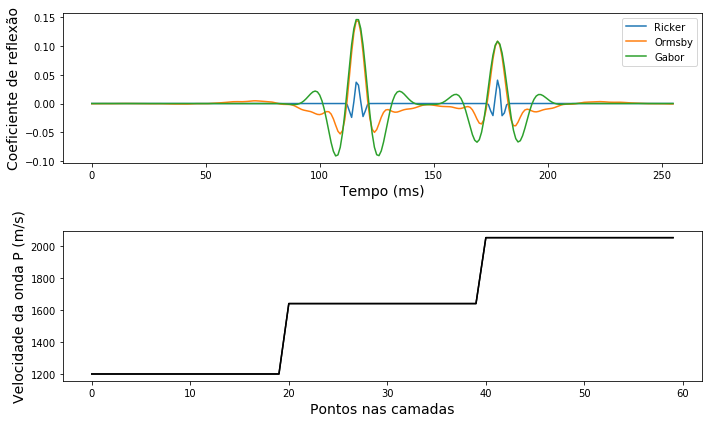

In [5]:
w_type = ['ricker','ormsby','gabor']
fig, axes = plt.subplots(nrows = 2, figsize=(10,6))

#Plotando os traços
models, vps, depths = get_models()
for i in range(3):
    synths = get_X(vps, depths, 0, wavelet_type = w_type[i])
    axes[0].plot(np.arange(0,len(synths[0]), 1), synths[0], label='{}'.format(w_type[i].capitalize()))
    
axes[0].legend()
axes[0].set_xlabel('Tempo (ms)', fontsize=14)
axes[0].set_ylabel('Coeficiente de reflexão', fontsize=14)

#Plotando as velocidades
axes[1].plot(np.arange(0,len(vps[0]),1), vps[0], c = 'black')
axes[1].plot(np.arange(0,len(vps[0]),1), vps[0], c = 'black')
axes[1].set_xlabel('Pontos nas camadas', fontsize=14)
axes[1].set_ylabel('Velocidade da onda P (m/s)', fontsize=14)

plt.tight_layout()

plt.savefig('traces&wavelets', dpi=300)

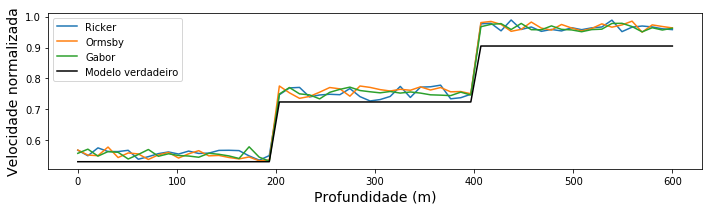

In [6]:
fig, axes = plt.subplots(figsize=(10,3))
w_types = ['ricker','ormsby','gabor']
y_pred = []
loss = []
mse = []

for i in range(3):
    
    y = np.array(vps)[:,:,0] # normalize model velocities
    max_vel = np.max(y)
    y /= max_vel

    # pad each seismogram with zeros so they are the same length
    max_size = int(np.max([el.shape[0] for el in synths]))
    pad_synths = []
    for s in synths:
        pad_width = max_size - int(s.shape[0])
        s = np.pad(s, pad_width=((0,pad_width),(0,0)), mode='constant', constant_values=[0])
        pad_synths.append(s)

    X = np.array(pad_synths)[:,:,0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


    nn = MLPRegressor(hidden_layer_sizes=(10, ), max_iter=1000, tol=1e-6)
    nn.fit(X_train,y_train)
    
    y_pred = nn.predict(X_test)
    
    # Computando o erro médio quadrático de cada uma das predições [Ricker,Ormsby,Gabor]
    mse.append(compute_misfit(y_pred, y_test)) 
    
    plt.plot(depths, y_pred[0],  label='{}'.format(w_type[i].capitalize()))


    loss.append(nn.loss_curve_)

plt.plot(depths,y[0], c = 'black', label='Modelo verdadeiro')
plt.xlabel('Profundidade (m)', fontsize=14)
plt.ylabel('Velocidade normalizada', fontsize=14)
plt.legend()
fig.tight_layout()

plt.savefig('result_wavelets', dpi=300)

In [7]:
print('Ricker MSE: {:.4f}'.format(mse[0]))
print('Ormsby MSE: {:.4f}'.format(mse[1]))
print('Gabor MSE: {:.4f}'.format(mse[2]))
print('')
print('Ricker RMSE: {:.4f}'.format(np.sqrt(mse[0])))
print('Ormsby RMSE: {:.4f}'.format(np.sqrt(mse[1])))
print('Gabor RMSE: {:.4f}'.format(np.sqrt(mse[2])))

Ricker MSE: 0.1834
Ormsby MSE: 0.1778
Gabor MSE: 0.1601

Ricker RMSE: 0.4283
Ormsby RMSE: 0.4216
Gabor RMSE: 0.4001


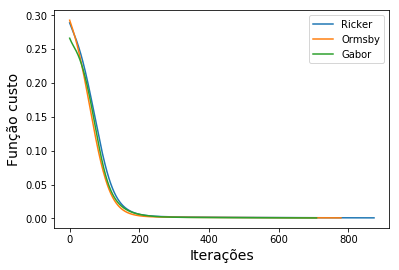

In [8]:
for i in range(len(loss)):
    plt.plot(loss[i], label='{}'.format(w_type[i].capitalize()))
             
plt.legend()
plt.xlabel('Iterações', fontsize=14)
plt.ylabel('Função custo', fontsize=14)

plt.savefig('result_loss_wavelets', dpi=300)

### Estudo da resposta com a variação da taxa de ruído no dado

Por critérios didáticos, este estudo será feito com a wavelet Ricker como padrão.

In [9]:
y = np.array(vps)[:,:,0] # normalize model velocities
max_vel = np.max(y)
y /= max_vel
max_vel

2271.0

In [10]:
# pad each seismogram with zeros so they are the same length
max_size = int(np.max([el.shape[0] for el in synths]))
pad_synths = []
for s in synths:
    pad_width = max_size - int(s.shape[0])
    s = np.pad(s, pad_width=((0,pad_width),(0,0)), mode='constant', constant_values=[0])
    pad_synths.append(s)

In [11]:
X = np.array(pad_synths)[:,:,0]

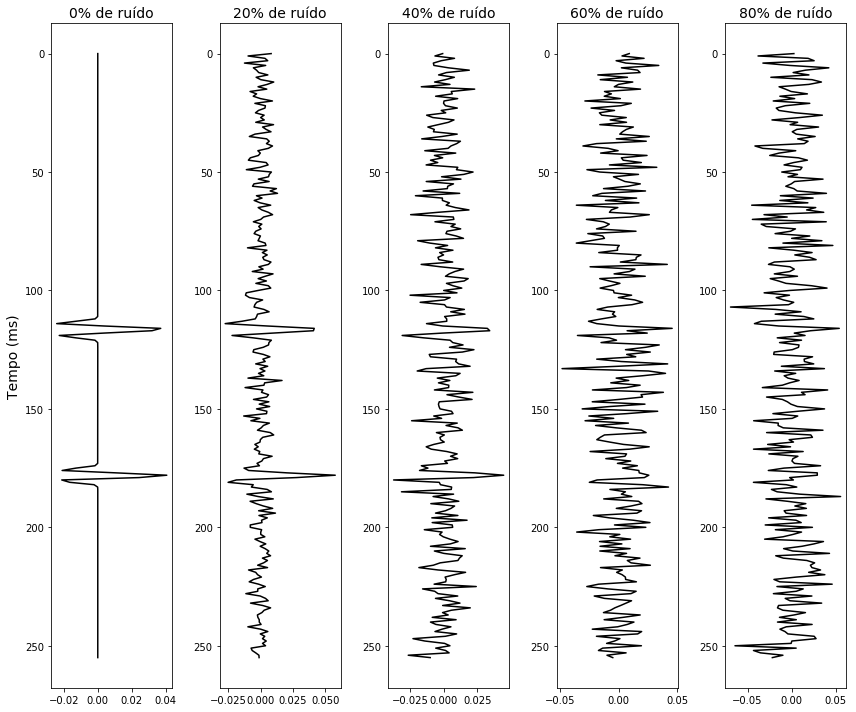

In [12]:
snr = [0, 0.2, 0.4, 0.6, 0.8]
fig, axes = plt.subplots(ncols = 5, figsize=(12,10))

for i in range(5):
    synths = get_X(vps, depths, snr=i, wavelet_type = 'ricker')
    axes[i].plot(synths[0], np.arange(0,len(synths[0]),1), c='black')

axes[0].set_ylabel('Tempo (ms)', fontsize=14)
axes[0].set_title('0% de ruído', fontsize=14)
axes[1].set_title('20% de ruído', fontsize=14)
axes[2].set_title('40% de ruído', fontsize=14)
axes[3].set_title('60% de ruído', fontsize=14)
axes[4].set_title('80% de ruído', fontsize=14)

for ax in axes:
    ax.invert_yaxis()

fig.tight_layout()

plt.savefig('traces&noises', dpi = 300)

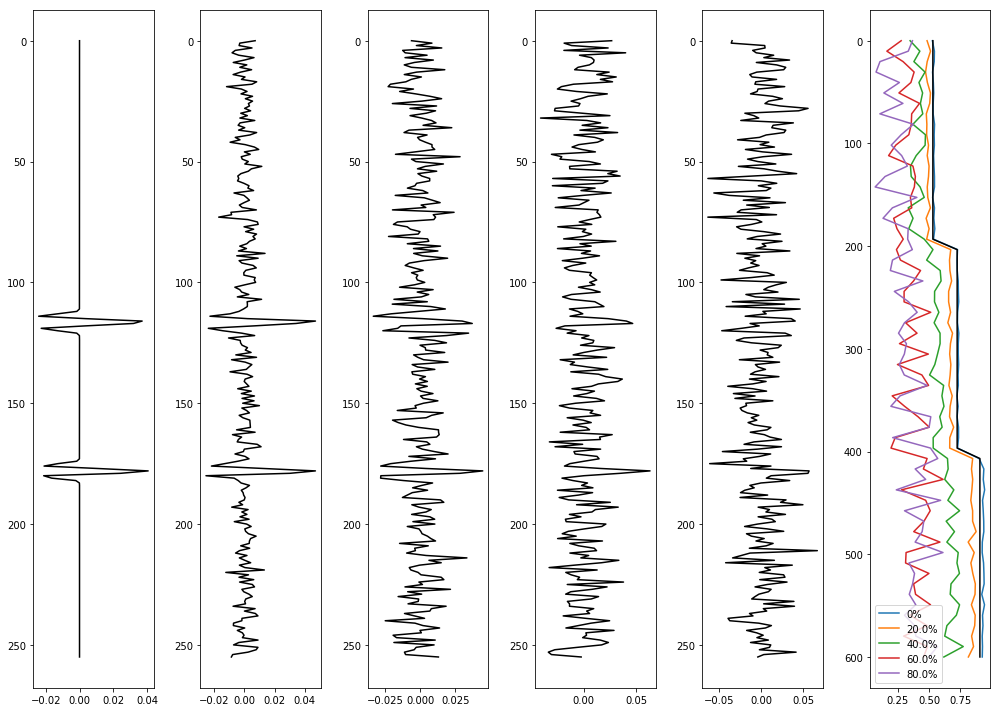

In [13]:
fig, axes = plt.subplots(ncols = 6, figsize=(14,10))
snr = [0, 0.2, 0.4, 0.6, 0.8]
y_pred = []
loss = []

for i in range(5):
    synths = get_X(vps, depths, snr=i, wavelet_type = 'ricker')
    axes[i].plot(synths[0], np.arange(0,len(synths[0]),1), c='black')
    
    y = np.array(vps)[:,:,0] # normalize model velocities
    max_vel = np.max(y)
    y /= max_vel

    # pad each seismogram with zeros so they are the same length
    max_size = int(np.max([el.shape[0] for el in synths]))
    pad_synths = []
    for s in synths:
        pad_width = max_size - int(s.shape[0])
        s = np.pad(s, pad_width=((0,pad_width),(0,0)), mode='constant', constant_values=[0])
        pad_synths.append(s)

    X = np.array(pad_synths)[:,:,0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


    nn = MLPRegressor(hidden_layer_sizes=(5, ), max_iter=10000, tol=1e-6)
    nn.fit(X_train,y_train)
    
    y_pred = nn.predict(X_test)
    axes[5].plot(y_pred[0], depths, label='{}%'.format(snr[i]*100))

    loss.append(nn.loss_curve_)
    
axes[5].plot(y[0], depths, c = 'black')
axes[5].legend()

for ax in axes:
    ax.invert_yaxis()
    #ax.legend()
fig.tight_layout()

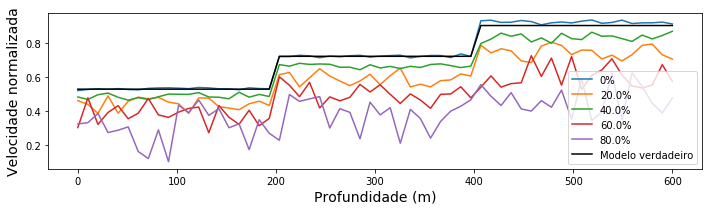

In [25]:
fig, axes = plt.subplots(figsize=(10,3))
snr = [0, 0.2, 0.4, 0.6, 0.8]
y_pred = []
loss = []
mse_noise = []
for i in range(5):

    synths = get_X(vps, depths, snr=i, wavelet_type = 'ricker')
    
    y = np.array(vps)[:,:,0] # normalize model velocities
    max_vel = np.max(y)
    y /= max_vel

    # pad each seismogram with zeros so they are the same length
    max_size = int(np.max([el.shape[0] for el in synths]))
    pad_synths = []
    for s in synths:
        pad_width = max_size - int(s.shape[0])
        s = np.pad(s, pad_width=((0,pad_width),(0,0)), mode='constant', constant_values=[0])
        pad_synths.append(s)

    X = np.array(pad_synths)[:,:,0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


    nn = MLPRegressor(hidden_layer_sizes=(5, ), max_iter=10000, tol=1e-6)
    nn.fit(X_train,y_train)
    
    y_pred = nn.predict(X_test)
    
    # Computando o erro médio quadrático de cada uma das predições [Ricker,Ormsby,Gabor]
    mse_noise.append(compute_misfit(y_pred, y_test))
    
    plt.plot(depths, y_pred[0],  label='{}%'.format(snr[i]*100))


    loss.append(nn.loss_curve_)

plt.plot(depths,y[0], c = 'black', label='Modelo verdadeiro')
plt.xlabel('Profundidade (m)', fontsize=14)
plt.ylabel('Velocidade normalizada', fontsize=14)
plt.legend()
fig.tight_layout()

plt.savefig('result_noise', dpi=300)

In [26]:
print('0% MSE: {:.4f}'.format(mse_noise[0]))
print('20% MSE: {:.4f}'.format(mse_noise[1]))
print('40% MSE: {:.4f}'.format(mse_noise[2]))
print('60% MSE: {:.4f}'.format(mse_noise[3]))
print('80% MSE: {:.4f}'.format(mse_noise[4]))
print('')
print('0% RMSE: {:.4f}'.format(np.sqrt(mse_noise[0])))
print('20% RMSE: {:.4f}'.format(np.sqrt(mse_noise[1])))
print('40% RMSE: {:.4f}'.format(np.sqrt(mse_noise[2])))
print('60% RMSE: {:.4f}'.format(np.sqrt(mse_noise[3])))
print('80% rMSE: {:.4f}'.format(np.sqrt(mse_noise[4])))

0% MSE: 0.0313
20% MSE: 0.9960
40% MSE: 1.7846
60% MSE: 2.4254
80% MSE: 5.4312

0% RMSE: 0.1769
20% RMSE: 0.9980
40% RMSE: 1.3359
60% RMSE: 1.5574
80% rMSE: 2.3305


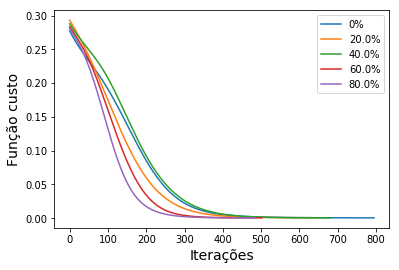

In [27]:
for i in range(len(loss)):
    plt.plot(loss[i], label='{}%'.format(snr[i]*100))
    
plt.xlabel('Iterações', fontsize=14)
plt.ylabel('Função custo', fontsize=14)
plt.legend()

#plt.savefig('loss_noise', dpi=300)